# Implementation of Integrated Gradients for tabular data

## Introduction

Integrated Gradients is introduced by this paper, Axiomatic Attribution for Deep Networks. (https://arxiv.org/abs/1703.01365) Google also introduced this algorithm to explain attributions of image data in https://www.tensorflow.org/tutorials/interpretability/integrated_gradients. However, one of the limitations is that this sample code is for image data, so it cannot be applied directly to tabular data. The goal of this document is to convert the source code into a modified version which works on tabular data with small changes.

The importance of explaining outputs of predictions from ML models is becoming more and more greater. Especially, for many business cases, decision makers want to know how a ML model makes its outcome in order to avoid potential problems or to understand how each variable relates to a response variable. Many data sets in the business environment consists of tabular data, so Integrated Gradients for tabular data will be very useful for those who want to explain their deep learning models.

In the last step of this document, everything is combined in one class in Python, so you will be able to use this python module in your project.

## Load libraries

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import *
from tqdm import tqdm

## Prepare data

I used california housing data for testing purpose.


### Download california housing data

In [ ]:
calhousing = datasets.fetch_california_housing()

In [ ]:
print(calhousing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [ ]:
df = pd.concat([pd.DataFrame(calhousing['target']), pd.DataFrame(calhousing['data'])], axis=1)

In [ ]:
df.columns = ['Target'] + calhousing['feature_names']

In [ ]:
df.head()

,Target,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,4.526,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,3.585,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,3.521,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,3.413,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.422,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
df.shape

(20640, 9)

### Split data

In [ ]:
col_x = df.columns[1:]
col_y = df.columns[0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[col_x], df[col_y], shuffle=True, random_state=0, train_size=0.8)

### Scale data

In [ ]:
x_scaler = StandardScaler()
x_train_std = x_scaler.fit_transform(x_train)
x_test_std = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_std = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_std = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

## Create a simple neural network model

To generate outputs of Integrated Gradients, we need a DL model.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_dim=df.shape[-1]-1))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(64, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(64, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2048      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                        

In [ ]:
epochs = 100
batch_size = 128
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True, patience=20)
hist = model.fit(x_train_std, y_train, epochs=epochs, batch_size=batch_size, 
                 validation_data=(x_test_std, y_test), callbacks=[reduce_lr, early_stop])

Epoch 1/100
129/129 [==============================] - 2s 8ms/step - loss: 1.2874 - val_loss: 2.1353 - lr: 0.0010
Epoch 2/100
129/129 [==============================] - 1s 6ms/step - loss: 0.4509 - val_loss: 0.9791 - lr: 0.0010
Epoch 3/100
129/129 [==============================] - 1s 4ms/step - loss: 0.4051 - val_loss: 0.4717 - lr: 0.0010
Epoch 4/100
129/129 [==============================] - 1s 5ms/step - loss: 0.3675 - val_loss: 1.0005 - lr: 0.0010
Epoch 5/100
129/129 [==============================] - 1s 6ms/step - loss: 0.3577 - val_loss: 0.3506 - lr: 0.0010
Epoch 6/100
129/129 [==============================] - 1s 6ms/step - loss: 0.3364 - val_loss: 0.8718 - lr: 0.0010
Epoch 7/100
129/129 [==============================] - 1s 6ms/step - loss: 0.3325 - val_loss: 0.3932 - lr: 0.0010
Epoch 8/100
129/129 [==============================] - 1s 4ms/step - loss: 0.3224 - val_loss: 0.3714 - lr: 0.0010
Epoch 9/100
129/129 [==============================] - 1s 5ms/step - loss: 0.3139 - val_

In [ ]:
y_pred = model.predict(x_test_std).reshape(-1)

In [ ]:
y_pred

array([1.4693351, 2.6133587, 1.2974439, ..., 1.3038476, 2.6460881,
       1.7276337], dtype=float32)

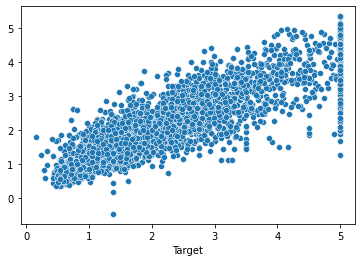

In [ ]:
sns.scatterplot(x=y_test, y=y_pred)

In [ ]:
r2_score(y_test, y_pred)

0.7805427045770255

In [ ]:
mean_squared_error(y_test, y_pred)

0.2861624162155299


## Implementation of Integrated Gradients

This algorithm analyzes changes in data, so in order to make changes in data we generate numbers in a certain range, alphas which will be multiplied by inputs. This leads to results that the intensity of each variable is increasing over alphas. In other words, if they are images, the first image is completely black, and they are more and more becoming brighter as the alpha is increasing. Finally, the last image shows its original shape.

In [ ]:
# alphas
m_steps = 50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
alphas

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
       0.09999999, 0.12      , 0.14      , 0.16      , 0.17999999,
       0.19999999, 0.22      , 0.24      , 0.26      , 0.28      ,
       0.29999998, 0.32      , 0.34      , 0.35999998, 0.38      ,
       0.39999998, 0.42      , 0.44      , 0.45999998, 0.48      ,
       0.5       , 0.52      , 0.53999996, 0.56      , 0.58      ,
       0.59999996, 0.62      , 0.64      , 0.65999997, 0.68      ,
       0.7       , 0.71999997, 0.74      , 0.76      , 0.78      ,
       0.79999995, 0.82      , 0.84      , 0.85999995, 0.88      ,
       0.9       , 0.91999996, 0.94      , 0.96      , 0.97999996,
       1.        ], dtype=float32)>

In [ ]:
# baseline
baseline = tf.zeros(shape=(x_train.shape[-1]))
#tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)
baseline

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
# interpolate
def interpolate_data(baseline, data, alphas):
    alphas_x = alphas[:, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(tf.cast(data, tf.float32), axis=0)
    delta = input_x - baseline_x
    outputs = baseline_x + alphas_x * delta
    return outputs

In [ ]:
interpolated_outputs = interpolate_data(baseline=baseline, data=x_train_std[0], alphas=alphas)
interpolated_outputs.shape

TensorShape([51, 8])

Test with numpy.

In [ ]:
interpolated_outputs.shape

TensorShape([51, 8])

In [ ]:
# alphas - numpy
steps = 50
alphas = np.linspace(start=0.0, stop=1.0, num=steps+1)
alphas

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [ ]:
# baseline - numpy
baseline = np.zeros(shape=(x_train.shape[-1]))
baseline
#np.random.uniform(size=x_train.shape[-1])

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# interpolate - numpy
def interpolate(baseline, data, alphas):
    alphas_x = alphas.reshape(-1, 1)
    baseline_x = baseline.reshape(1, -1)
    input_x = data.reshape(1, -1)
    delta = input_x - baseline_x
    outputs = baseline_x + alphas_x * delta
    return outputs

In [ ]:
inter_outputs_np = interpolate(baseline=baseline, data=x_train_std[0], alphas=alphas)

In [ ]:
# get gradients
def get_gradients(data, y_idx=1, classification=True):
    with tf.GradientTape() as tape:
        tape.watch(data)
        logits = model(data)
        if classification:
            probs = tf.nn.softmax(logits, axis=-1)[:, y_idx]
        else:
            probs = logits
    return tape.gradient(probs, data)

In [ ]:
grads = get_gradients(data=interpolated_outputs, classification=False)
grads.shape

TensorShape([51, 8])

In [ ]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [ ]:
ig = integral_approximation(grads)
ig.shape

TensorShape([8])

In [ ]:
@tf.function
def integrated_gradients(data, y_idx=1, m_steps=50, batch_size=30, classification=True):
    data = tf.cast(data, tf.float32)
    baseline = tf.zeros(shape=(x_train.shape[-1]))
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
 
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

    for alpha in tf.range(0, len(alphas), batch_size):
        start = alpha
        end = tf.minimum(start + batch_size, len(alphas))
        alpha_batch = alphas[start:end]

        outputs_batch = interpolate_data(baseline=baseline, data=data, alphas=alpha_batch)
        gradient_batch = get_gradients(data=outputs_batch, y_idx=y_idx, classification=classification)
        gradient_batches = gradient_batches.scatter(tf.range(start, end), gradient_batch)    

    total_gradients = gradient_batches.stack()
    avg_gradients = integral_approximation(gradients=total_gradients)
    integrated_gradients = (data - baseline) * avg_gradients

    return integrated_gradients

In [ ]:
integrated_gradients(data=x_train_std[0], classification=False)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 0.10492647,  0.06232742,  0.402466  , -0.0322178 ,  0.5019936 ,
       -0.00896493,  2.598618  , -1.3619306 ], dtype=float32)>

Combine everything in a class and then make a module.

The name of module is **igtab**. You will be able to load the class in a way described below.

## Load the explainer

**igtab** has more features than the sample code above. 

- Supports 2 initializing methods: zeros, random values from the uniform distribution
- Supports 4 types of models: binary classification, multiclass classification, regression, autoencoder for anomaly detection

In [ ]:
from igtab import Explainer

In [ ]:
ig_deep = TabularExplainer(model=model, type=None)

In [ ]:
res = ig_deep.ig_values(x_train_std)

100%|██████████| 16512/16512 [00:19<00:00, 861.69it/s]


In [ ]:
ig_deep.result.shape

(16512, 8)

The detail of how to use this algorithm is explained in a different document. I recommend you to use the python module in my github instead of copying source code in this jupyter notebook.